In [1]:
%matplotlib inline

import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import train_test_split
from itertools import product
import collections
import math
import random
import matplotlib.pyplot as plt
import numpy as np

from utils import ModelTrainer
from datasets import avGFPDataset, GB1Dataset, SGEMMDataset, EntacmaeaDataset

In [2]:
class FCN(nn.Module):
    def __init__(self, n, multiplier=2, batch_norm=False):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(n, multiplier*n)
        self.fc2 = nn.Linear(multiplier*n, multiplier*n)
        self.fc3 = nn.Linear(multiplier*n, n)
        self.fc4 = nn.Linear(n, 1)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        torch.nn.init.xavier_uniform_(self.fc4.weight)
        
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn1 = nn.BatchNorm1d(multiplier*n)
            self.bn2 = nn.BatchNorm1d(multiplier*n)
            self.bn3 = nn.BatchNorm1d(n)

    def forward(self, x):
        if self.batch_norm:
            x = self.bn1(F.leaky_relu(self.fc1(x)))
            x = self.bn2(F.leaky_relu(self.fc2(x)))
            x = self.bn3(F.leaky_relu(self.fc3(x)))
            x = self.fc4(x)
        else:
            x = F.leaky_relu(self.fc1(x))
            x = F.leaky_relu(self.fc2(x))
            x = F.leaky_relu(self.fc3(x))
            x = self.fc4(x)

        return x.reshape(-1)

Loaded dataset from cache.
Fourier quality:	Sample R2:0.856	Train R2:0.773
#0 - Train Loss: 0.680, R2: -0.111	Validation Loss: 0.951, R2: 0.049	alternate_loss: 0.04168
Fourier quality:	Sample R2:0.906	Train R2:0.880
#1 - Train Loss: 0.492, R2: 0.196	Validation Loss: 0.974, R2: 0.026	alternate_loss: 0.04104
Fourier quality:	Sample R2:0.925	Train R2:0.892
#2 - Train Loss: 0.417, R2: 0.320	Validation Loss: 0.882, R2: 0.118	alternate_loss: 0.02894
Fourier quality:	Sample R2:0.942	Train R2:0.866
#3 - Train Loss: 0.338, R2: 0.447	Validation Loss: 0.837, R2: 0.163	alternate_loss: 0.02616
Fourier quality:	Sample R2:0.942	Train R2:0.777
#4 - Train Loss: 0.229, R2: 0.627	Validation Loss: 0.811, R2: 0.189	alternate_loss: 0.05530
Fourier quality:	Sample R2:0.927	Train R2:0.685
#5 - Train Loss: 0.137, R2: 0.776	Validation Loss: 0.754, R2: 0.246	alternate_loss: 0.14969
Fourier quality:	Sample R2:0.944	Train R2:0.569
#6 - Train Loss: 0.115, R2: 0.812	Validation Loss: 0.758, R2: 0.242	alternate_loss: 

Fourier quality:	Sample R2:0.935	Train R2:0.428
#58 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.728, R2: 0.273	alternate_loss: 0.35447
Fourier quality:	Sample R2:0.909	Train R2:0.414
#59 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.737, R2: 0.263	alternate_loss: 0.34793
Fourier quality:	Sample R2:0.937	Train R2:0.418
#60 - Train Loss: 0.000, R2: 0.999	Validation Loss: 0.733, R2: 0.267	alternate_loss: 0.34767
Fourier quality:	Sample R2:0.926	Train R2:0.426
#61 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.727, R2: 0.273	alternate_loss: 0.35214
Fourier quality:	Sample R2:0.946	Train R2:0.419
#62 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.733, R2: 0.267	alternate_loss: 0.34917
Fourier quality:	Sample R2:0.926	Train R2:0.419
#63 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.731, R2: 0.269	alternate_loss: 0.34814
Fourier quality:	Sample R2:0.932	Train R2:0.429
#64 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.726, R2: 0.274	alternate_loss: 0.35735
Fourier quali

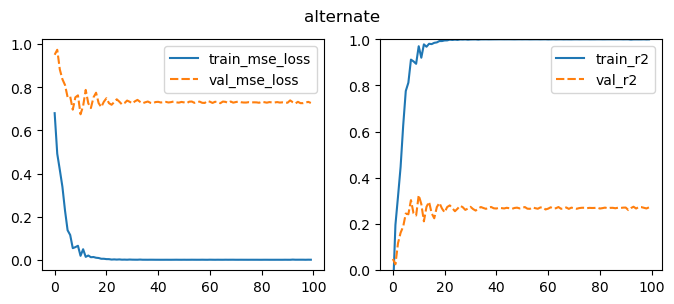

In [5]:
fix_seed = 1
random_seed = 11
dataset = "SGEMM"

train_size = 40

config = {
    "training_method": "hashing",
    "b": 10,
    "lr": 0.01, 
    "weight_decay": 0, 
    "hadamard_lambda": 0.0001,
    "num_epochs": 50,
    "random_seed": random_seed,
    "fix_seed": fix_seed,
    "train_size": train_size,
    "dataset": dataset,
    "batch_size": 16,
    "normalize": True,
}

config = {
    "training_method": "normal",
    "lr": 0.01, 
    "weight_decay": 0, 
    "num_epochs": 100,
    "random_seed": random_seed,
    "fix_seed": fix_seed,
    "train_size": train_size,
    "batch_size": 16,
    "dataset": dataset,
    "normalize": True
}

# config = {
#     "training_method": "EN-S",
#     "SPRIGHT_d": 3,
#     "rho": 0.01,
#     "b": 7,
#     "lr": 0.01, 
#     "weight_decay": 0, 
#     "hadamard_lambda": 1,
#     "num_epochs": 100,
#     "random_seed": random_seed,
#     "fix_seed": fix_seed,
#     "train_size": train_size,
#     "batch_size": 16,
#     "dataset": dataset,
#     "normalize": True
# }

config = {
    "training_method": "alternate",
    "b": 10,
    "lr": 0.01, 
    "SPRIGHT_d": 3,
    "weight_decay": 0, 
    "hadamard_lambda": 0.01,
    "num_epochs": 100,
    "random_seed": random_seed,
    "fix_seed": fix_seed,
    "train_size": train_size,
    "dataset": dataset,
    "batch_size": 16,
    "normalize": True,
    "intense_regularization": True,
    "fourier_method": "swht",
    "fourier_d": 14,
    "warmup_epochs": 0,
}

    
# Dataset
torch.manual_seed(config["fix_seed"])
if dataset == "GB1":
    dataset = GB1Dataset()
elif dataset == "avGFP":
    dataset = avGFPDataset()
elif dataset == "SGEMM":
    dataset = SGEMMDataset()
elif dataset == "Entacmaea":
    dataset = EntacmaeaDataset()
else:
    raise Exception
    
if config.get("normalize", False):
    dataset.y = (dataset.y-torch.mean(dataset.y))/torch.std(dataset.y)
dataset_size = len(dataset)
train_ds, val_ds = torch.utils.data.random_split(dataset, [config["train_size"], dataset_size - config["train_size"]])

# Train model
torch.manual_seed(config["random_seed"]) # Seed for network initialization
in_dim = dataset.X.shape[1]
model = FCN(in_dim, 1, batch_norm=False)
trainer = ModelTrainer(model, train_ds, val_ds, config=config,  plot_results=True, checkpoint_cache=True)
model = trainer.train_model()
print(max([l["val_r2"] for l in trainer.logs]))


In [ ]:
dataset.X.shape

In [ ]:
loss = nn.L1Loss(reduction='sum')
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
output.backward()

In [ ]:
output

In [ ]:
input

In [ ]:
torch.abs(input - target)

In [ ]:
torch.sum(torch.abs(input - target), axis=1)